       fold  mag    grp                                           filename
0         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
1         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
2         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
3         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
4         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
...     ...  ...    ...                                                ...
39540     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39541     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39542     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39543     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39544     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...

[39545 rows x 4 columns]
   fold  mag    grp                                               path  \


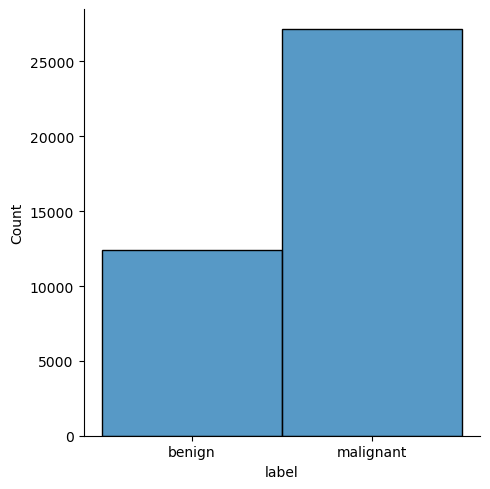

['benign', 'malignant']
{'benign': 0, 'malignant': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9657763240337373].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9999999964237213].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.999956268310547].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9112948532104492].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.8626057980060577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9543940808773042].
Clipp

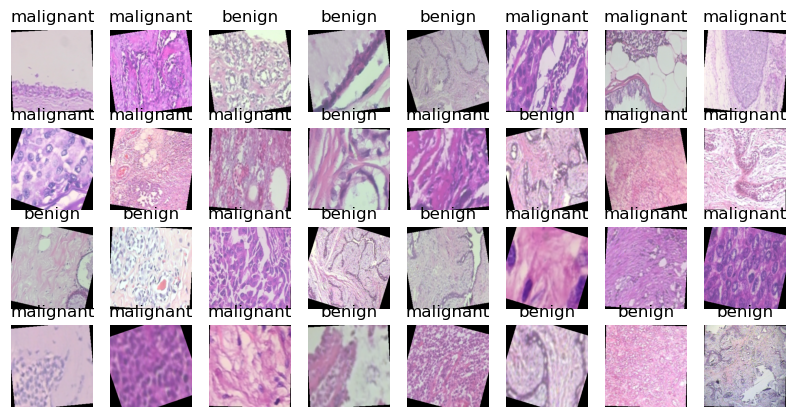

train   :  25880
vali :  10932
test :  2733


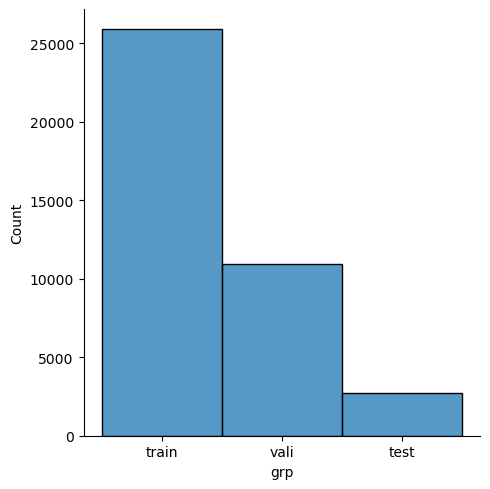

grp
train    25880
vali     10932
test      2733
Name: count, dtype: int64


In [1]:
%run  dataset_preprocessing.ipynb

In [3]:
#se importa la libreria del modelo preentrenado

from transformers import DeiTFeatureExtractor, DeiTForImageClassification

# Verifica si CUDA está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando el dispositivo: {device}")

# Cargar el modelo preentrenado
model = DeiTForImageClassification.from_pretrained("facebook/deit-tiny-distilled-patch16-224")

# Modificar la última capa para que coincida con el número de clases de tu conjunto de datos
num_classes = 2
model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)

# Mover el modelo a la GPU si está disponible
model.to(device)

Usando el dispositivo: cuda


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): L

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.0005)

In [ ]:
# Listas para pérdidas y precisión
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Entrenamiento y evaluación
epochs = 6
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Entrenamiento
    for inputs, labels in train_loader:

        # Mover datos a la GPU si está disponible
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calcular precisión en el conjunto de entrenamiento
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Evaluación en el conjunto de validación
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in vali_loader:

            # Mover datos a la GPU si está disponible
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs).logits
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()
            
            # Calcular precisión en el conjunto de validación
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = running_val_loss / len(vali_loader)
    val_losses.append(val_loss)
    
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, "
          f"Train Acc: {train_accuracy}, Val Acc: {val_accuracy}")

In [ ]:
# Graficar las pérdidas
def plot_losses(train_losses, val_losses):
    # Usar el tamaño más pequeño entre train_losses y val_losses para los epochs
    epochs = range(1, min(len(train_losses), len(val_losses)) + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses[:len(epochs)], label='Training Loss')  # Asegurarse de que los tamaños coincidan
    plt.plot(epochs, val_losses[:len(epochs)], label='Validation Loss')  # Cortar si hay más valores
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar a la función para graficar después del entrenamiento
plot_losses(train_losses, val_losses)



In [ ]:
def test_model(model, vali_loader):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in vali_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Obtener los logits del modelo
            outputs = model(inputs).logits  
            
            # Obtener la predicción más probable
            _, predicted = torch.max(outputs, 1)
            
            # Contar las predicciones correctas
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    
    # Calcular y mostrar la precisión
    accuracy = correct_predictions / total_samples
    print(f'Accuracy on test set: {accuracy:.4f}')

# Llama a la función de prueba del modelo
test_model(model, vali_loader)


In [ ]:
# Guardar el estado del modelo
torch.save(model, 'DeiT_Tiny.pth')

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Etiquetas verdaderas y predicciones del modelo
y_true = []
y_pred = []

# Desactivar gradientes para el cálculo (modo evaluación)
with torch.no_grad():
    for data in test_loader:  # Se asume que test_loader está definido
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Obtener predicciones
        outputs = model(inputs)

        # Si la salida es un objeto ImageClassifierOutput, accede a los logits:
        outputs = outputs.logits if hasattr(outputs, 'logits') else outputs
        _, predicted = torch.max(outputs, 1)

        # Guardar las etiquetas reales y predichas
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_true, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión ViT base')
plt.show()


In [ ]:
# Nombres de las etiquetas
class_names = ['Benigno', 'Maligno']

# Generar la matriz de confusión (supongamos que ya tienes las predicciones y etiquetas verdaderas)
cm = confusion_matrix(y_true, y_pred)

# Configurar el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)

# Etiquetas y título
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión DeiT-tiny')
plt.show()